### Chase Checking Account - Expense Trends (5/2018-5/2025)

<hr>

In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression



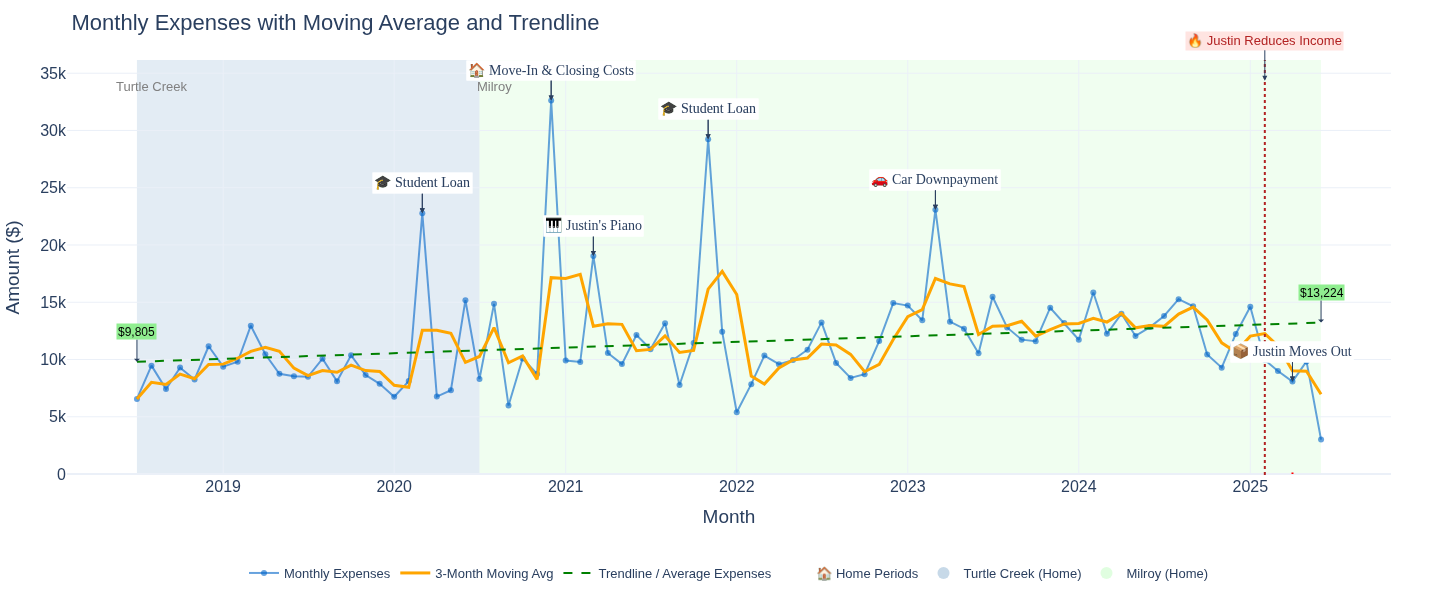

In [6]:

df = pd.read_csv('normalized_data.csv')
# ==== FILTER + AGGREGATE ====
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df = df.dropna(subset=['date', 'amount'])
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()

# Filter relevant categories
categories_of_interest = [
    'Misc Household Expense', 'Groceries', 'Medical / Medicine',
    'Utility Account', 'Amazon.com', 'Justin - Car',
    'Spenser - Car', 'Mortgage and Housing', 'Spenser - Educational Expense', 'Restaurant Expense',
    'Spenser - Mother', 'Misc Entertainment', 'Justin - Solo Entertainment', 'Spenser - Solo Entertainment',
    'Justin - Moving from Milroy', 'Checking Withdrawal',
]

expenses_df = df[df['normalized_payee'].isin(categories_of_interest)].copy()
expenses_df = expenses_df[
    (expenses_df['date'] >= pd.Timestamp('2018-07-01')) &
    (expenses_df['date'] <= pd.Timestamp('2025-06-28'))
]
monthly_expenses = expenses_df.groupby('month')['amount'].sum().abs()

# Income series
income_df = df[df['normalized_payee'].isin(['Spenser Income', 'Justin Income'])].copy()
monthly_income = income_df.groupby('month')['amount'].sum()

# Combine and compute %
combined = pd.concat([monthly_expenses, monthly_income], axis=1)
combined.columns = ['expenses', 'income']
combined = combined.dropna()
combined['pct_of_income'] = combined['expenses'] / combined['income'] * 100


# Smooth and trendline
smoothed = combined['pct_of_income'].rolling(window=3, min_periods=1).mean()
X = np.arange(len(smoothed)).reshape(-1, 1)
y = smoothed.values
model = LinearRegression().fit(X, y)
trend = model.predict(X)

# ==== MOVING AVERAGE ====
smoothed = monthly_expenses.rolling(window=3, min_periods=1).mean()

# ==== TRENDLINE ====
X = np.arange(len(smoothed)).reshape(-1, 1)
y = smoothed.values
model = LinearRegression().fit(X, y)
trend = model.predict(X)

# ==== HOVER DETAIL DATA ====
def format_hover(row):
    sorted_items = sorted(row.items(), key=lambda x: abs(x[1]), reverse=True)
    return '<br>'.join(f"{col}: ${abs(amt):,.2f}" for col, amt in sorted_items if amt != 0)

hover_data = (
    filtered_df.groupby(['month', 'normalized_payee'])['amount']
    .sum()
    .unstack(fill_value=0)
    .apply(format_hover, axis=1)
)
hover_data.index = hover_data.index.to_timestamp()

# ==== Find Top Expense Months ====
top_expenses = monthly_expenses.sort_values(ascending=False)
labels = {
    top_expenses.index[0]: "🏠 Move-In & Closing Costs",
    top_expenses.index[1]: "🎓 Student Loan",
    top_expenses.index[3]: "🎓 Student Loan",
    top_expenses.index[2]: "🚗 Car Downpayment",
    top_expenses.index[4]: "🎹 Justin's Piano",
    pd.Timestamp("2025-04-01"): "📦 Justin Moves Out",
}

# ==== Plotly Plot ====
fig = go.Figure()

# Monthly Expenses
fig.add_trace(go.Scatter(
    x=monthly_expenses.index,
    y=monthly_expenses,
    mode='lines+markers',
    name='Monthly Expenses',
    line=dict(color='rgba(0,100,200,0.6)', width=2),
    text=hover_data.reindex(monthly_expenses.index, fill_value=''),
    hoverinfo='text+y'
))

# Moving Average
fig.add_trace(go.Scatter(
    x=smoothed.index,
    y=smoothed,
    mode='lines',
    name='3-Month Moving Avg',
    line=dict(color='orange', width=3)
))

# Trendline
fig.add_trace(go.Scatter(
    x=monthly_expenses.index,
    y=trend,
    mode='lines',
    name='Trendline / Average Expenses',
    line=dict(color='green', width=2, dash='dash')
))

# Add shaded home periods
fig.add_vrect(
    x0="2018-07-01", x1="2020-07-01",
    fillcolor="rgba(70, 130, 180, 0.15)", layer="below", line_width=0
)
fig.add_annotation(
    x=pd.Timestamp("2018-08-01"),
    yref="paper",
    y=0.96,
    text="Turtle Creek",
    showarrow=False,
    font=dict(size=13, color="gray")
)
fig.add_vrect(
    x0="2020-07-01", x1="2025-06-01",
    fillcolor="rgba(152, 251, 152, 0.15)", layer="below", line_width=0
)
fig.add_annotation(
    x=pd.Timestamp("2020-08-01"),
    yref="paper",
    y=0.96,
    text="Milroy",
    showarrow=False,
    font=dict(size=13, color="gray")
)
# Optional: Emphasize visually with a shape marker or callout
fig.add_shape(
    type="line",
    x0="2025-04-01",
    x1="2025-04-01",
    y0=0,
    y1=combined['pct_of_income'].max(),
    line=dict(color="red", width=2, dash="dot"),
    layer="above"
)

# Inside your loop:
for date, label in labels.items():
    is_milroy = "Milroy" in label
    fig.add_annotation(
        x=date,
        y=monthly_expenses.get(date, smoothed.get(date, 0)),
        text=label,
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-30 if is_milroy else -30,  # <--- make it shorter
        bgcolor="white",
        font=dict(size=14, family="Segoe UI Emoji")
    )


for date, label in labels.items():
    y_val = monthly_expenses.get(date, smoothed.get(date, 0))
    bgcolor = "rgba(255,255,255,0.8)" if "Student Loan" in label else "white"

    fig.add_annotation(
        x=date,
        y=y_val,
        text=label,
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-30,
        bgcolor=bgcolor,
        font=dict(size=14, family="Segoe UI Emoji")
    )


# Annotate beginning and end of trendline
fig.add_annotation(
    x=monthly_expenses.index[0],
    y=trend[0],
    text=f"${trend[0]:,.0f}",
    showarrow=True,
    arrowhead=1,
    ax=0,
    ay=-30,
    bgcolor="lightgreen",
    font=dict(size=12, color="black")
)
fig.add_annotation(
    x=monthly_expenses.index[-1],
    y=trend[-1],
    text=f"${trend[-1]:,.0f}",
    showarrow=True,
    arrowhead=1,
    ax=0,
    ay=-30,
    bgcolor="lightgreen",
    font=dict(size=12, color="black")
)

# Dummy traces to display legend for home periods
fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='markers',
    marker=dict(size=0, color='rgba(0,0,0,0)'),
    name="🏠 Home Periods"
))
fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='markers',
    marker=dict(size=12, color='rgba(70, 130, 180, 0.3)'),  # Turtle Creek color
    name="Turtle Creek (Home)"
))
fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='markers',
    marker=dict(size=12, color='rgba(152, 251, 152, 0.3)'),  # Milroy color
    name="Milroy (Home)"
))

# Layout
fig.update_layout(
    title='Monthly Expenses with Moving Average and Trendline',
    xaxis_title='Month',
    yaxis_title='Amount ($)',
    template='plotly_white',
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.2,
        xanchor="center",
        x=0.5,
        traceorder="normal",
        font=dict(size=13)
    ),
    width=1200,
    height=600,
    font=dict(size=16),
    margin=dict(l=60, r=40, t=60, b=100)  # Increase bottom margin slightly for space
)

fig.add_shape(
    type="line",
    x0="2025-02-01",
    x1="2025-02-01",
    y0=0,
    y1=1,
    yref="paper",  # use full chart height
    line=dict(color="firebrick", width=2, dash="dot"),
    layer="above"
)

fig.add_annotation(
    x="2025-02-01",
    y=0.95,
    yref="paper",
    text="🔥 Justin Reduces Income",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-40,
    font=dict(size=13, color="firebrick"),
    bgcolor="mistyrose"
)

fig.show()